In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from g_media_pipe import extract_data_from_video, save_data
import ast
import glob
import os

In [2]:
directory = os.path.join("model_data")
csv_files = glob.glob(os.path.join(directory,"Bicep_Curls","Proper","*.csv"))
csv_files

['model_data/Bicep_Curls/Proper/properDumbellFront.csv']

In [3]:
def euclidean(joint1,joint2):
        joint1 = eval(joint1)
        joint2 = eval(joint2)
        xi,yi,zi = joint1
        xj,yj,zj = joint2
        return (np.square(xi-xj)+np.square(yi-yj)+np.square(zi-zj))**0.5

def calculate_joint_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

def smooth_gaussian(data:pd.Series, sigma=2)->pd.Series:
    """
    Smoothen the curves using a Gaussian filter.
    Parameters:
    - data: NumPy array, the input signal to smooth.
    - sigma: Standard deviation of the Gaussian kernel.
    Returns:
    - smoothed_data: NumPy array of the smoothed data.
    """
    kernel_radius = int(3 * sigma)  # 3 standard deviations cover ~99% of data
    x = np.arange(-kernel_radius, kernel_radius + 1)
    gaussian_kernel = np.exp(-x**2 / (2 * sigma**2))
    gaussian_kernel /= gaussian_kernel.sum()  # Normalize the kernel
    
    # Padding to avoid edge effects
    padded_data = np.pad(data, pad_width=kernel_radius, mode='edge')
    
    # Convolution with Gaussian kernel
    smoothed_data = np.convolve(padded_data, gaussian_kernel, mode='valid')
    
    return pd.Series(smoothed_data,index=data.index)

def calculate_angle(joint_a, joint_b, joint_c):
    """
    Calculate the angle between three joints in 3D space using numpy.
    
    Args:
    joint_a (tuple): The (x, y, z) coordinates of the first joint.
    joint_b (tuple): The (x, y, z) coordinates of the second joint (vertex joint).
    joint_c (tuple): The (x, y, z) coordinates of the third joint.
    
    Returns:
    float: The angle in degrees between the three joints.
    """
    # Convert joint coordinates to numpy arrays
    joint_a = np.array(joint_a, dtype=float)
    joint_b = np.array(joint_b, dtype=float)
    joint_c = np.array(joint_c, dtype=float)

    # Calculate vectors: Joint A to B and Joint B to C
    vector_ab = joint_b - joint_a
    vector_bc = joint_c - joint_b
    
    # Calculate dot product and magnitudes using numpy
    dot_product = np.dot(vector_ab, vector_bc)
    magnitude_ab = np.linalg.norm(vector_ab)
    magnitude_bc = np.linalg.norm(vector_bc)
    
    # Avoid division by zero by ensuring valid magnitude values
    if magnitude_ab == 0 or magnitude_bc == 0:
        raise ValueError("One of the vectors has zero length, can't calculate angle.")
    
    # Calculate the cosine of the angle
    cos_theta = dot_product / (magnitude_ab * magnitude_bc)
    
    # Ensure cos_theta is within [-1, 1] to avoid domain errors
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Calculate the angle in radians, then convert to degrees
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def joint_angles_per_record(record, joints):
    """
    Calculate the joint angle for a single record (pd.Series).
    
    Args:
    record (pd.Series): A single row from a DataFrame containing joint positions.
    joints (list): List of three joint names as strings (column names).
    
    Returns:
    float: The calculated angle for the given joints in the record.
    """
    joint_a, joint_b, joint_c = joints

    # Extract joint coordinates directly from the record
    a_coords = record[joint_a]
    b_coords = record[joint_b]
    c_coords = record[joint_c]
    
    # Convert string of coordinates to tuple (x, y, z) if necessary
    if isinstance(a_coords, (list, tuple)):
        pass  # already in (x, y, z) format
    if isinstance(a_coords,str):
        a_coords = ast.literal_eval(a_coords)
        b_coords = ast.literal_eval(b_coords)
        c_coords = ast.literal_eval(c_coords)
    else:
        a_coords = tuple(a_coords)
        b_coords = tuple(b_coords)
        c_coords = tuple(c_coords)
    # Calculate the angle between the joints
    angle = calculate_angle(a_coords, b_coords, c_coords)
    
    return angle

def plot_joint_angles(df, joints, angle_name="Angle"):
    """
    Calculate and plot joint angles over time.

    Args:
    df (pd.DataFrame): DataFrame containing joint positions for each timeframe.
    joints (list): List of three joints as tuples of (x, y, z) columns.
    angle_name (str): Name for the angle being calculated.
    """
    joint_a, joint_b, joint_c = joints
    
    # Initialize an empty list to store the angles
    angles = []
    
    # Iterate over each row (timeframe) in the DataFrame
    for _, row in df.iterrows():
        # Extract joint coordinates
        a_coords = row[joint_a]
        b_coords = row[joint_b]
        c_coords = row[joint_c]
        if isinstance(a_coords,str):
            a_coords = ast.literal_eval(a_coords)
            b_coords = ast.literal_eval(b_coords)
            c_coords = ast.literal_eval(c_coords)
        # Calculate angle and append to list
        angle = calculate_angle(a_coords, b_coords, c_coords)
        angles.append(angle)
    angles = smooth_gaussian(pd.Series(angles))
    
    # Plot the angles over time
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, angles, label=f'{angle_name}')
    plt.xlabel("Timeframe")
    plt.ylabel("Angle (degrees)")
    plt.title(f'{angle_name} Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
df = pd.read_csv(csv_files[0])
df = df[["LEFT_THUMB","LEFT_WRIST","LEFT_ELBOW","LEFT_SHOULDER","RIGHT_THUMB", "RIGHT_WRIST", "RIGHT_ELBOW","RIGHT_SHOULDER"]]
df.head()

,LEFT_THUMB,LEFT_WRIST,LEFT_ELBOW,LEFT_SHOULDER,RIGHT_THUMB,RIGHT_WRIST,RIGHT_ELBOW,RIGHT_SHOULDER
0,"[0.5792677998542786, 0.6375810503959656, -0.08...","[0.5746462941169739, 0.6152817606925964, -0.07...","[0.5507841110229492, 0.5030269026756287, -0.01...","[0.541536808013916, 0.3538563847541809, -0.062...","[0.4181043207645416, 0.6566473245620728, -0.11...","[0.4185994267463684, 0.6318515539169312, -0.09...","[0.43267449736595154, 0.5037679672241211, -0.0...","[0.4403519034385681, 0.356966108083725, -0.063..."
1,"[0.5782355070114136, 0.6379038095474243, -0.09...","[0.5744699835777283, 0.6148462295532227, -0.08...","[0.551915168762207, 0.5004949569702148, -0.025...","[0.5412569046020508, 0.35369673371315, -0.0600...","[0.4182000160217285, 0.6572652459144592, -0.10...","[0.4189673066139221, 0.6319037079811096, -0.08...","[0.4327622950077057, 0.5045499205589294, -0.03...","[0.4396570324897766, 0.35687658190727234, -0.0..."
2,"[0.5772549510002136, 0.6381073594093323, -0.10...","[0.5742236375808716, 0.6145332455635071, -0.08...","[0.55219566822052, 0.4994146227836609, -0.0273...","[0.5409513711929321, 0.3536910116672516, -0.05...","[0.41822558641433716, 0.6582738161087036, -0.1...","[0.4191509187221527, 0.6323164701461792, -0.08...","[0.4328206479549408, 0.505233108997345, -0.028...","[0.4393838346004486, 0.3568682372570038, -0.04..."
3,"[0.5765064358711243, 0.6385201811790466, -0.09...","[0.573837399482727, 0.6145120859146118, -0.086...","[0.5522875189781189, 0.49915000796318054, -0.0...","[0.540813684463501, 0.35377466678619385, -0.05...","[0.418274462223053, 0.6590861678123474, -0.100...","[0.4192878305912018, 0.6327757239341736, -0.08...","[0.43283018469810486, 0.5057715773582458, -0.0...","[0.43920597434043884, 0.35689395666122437, -0...."
4,"[0.5762943029403687, 0.6391196250915527, -0.10...","[0.5736729502677917, 0.614753782749176, -0.088...","[0.5524293780326843, 0.499153733253479, -0.027...","[0.5407495498657227, 0.3540990650653839, -0.05...","[0.4182523787021637, 0.6599588394165039, -0.09...","[0.4192383885383606, 0.6335858106613159, -0.08...","[0.43281620740890503, 0.5064775347709656, -0.0...","[0.43907538056373596, 0.35700538754463196, -0...."


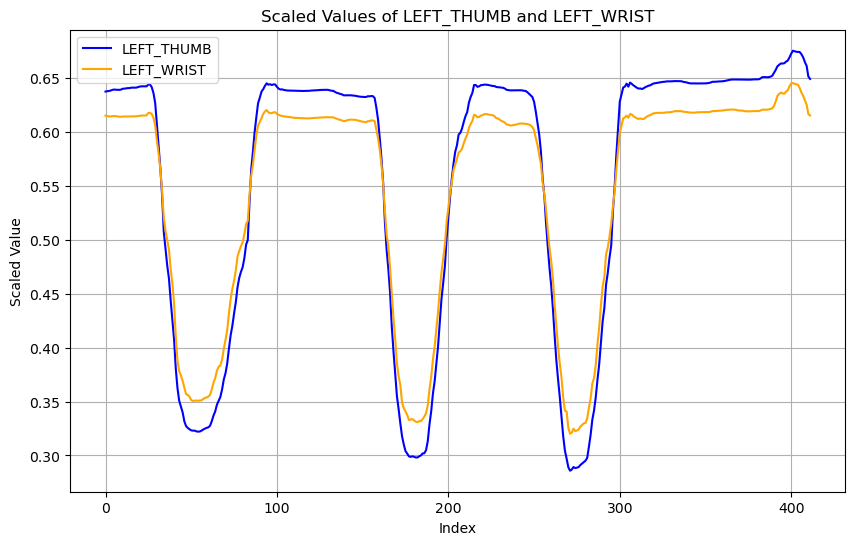

In [5]:
temp_df = df[['LEFT_THUMB','LEFT_WRIST']].map(lambda x: eval(x)[1])

#temp_df['LEFT_THUMB'] = (temp_df['LEFT_THUMB']-temp_df['LEFT_THUMB'].min())/(temp_df['LEFT_THUMB'].max()-temp_df['LEFT_THUMB'].min())
#temp_df['LEFT_WRIST'] = (temp_df['LEFT_WRIST']-temp_df['LEFT_WRIST'].min())/(temp_df['LEFT_WRIST'].max()-temp_df['LEFT_WRIST'].min())
plt.figure(figsize=(10, 6))
plt.plot(temp_df['LEFT_THUMB'], label='LEFT_THUMB', color='blue')
plt.plot(temp_df['LEFT_WRIST'], label='LEFT_WRIST', color='orange')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Scaled Value')
plt.title('Scaled Values of LEFT_THUMB and LEFT_WRIST')
plt.legend()
plt.grid(True)
plt.show()

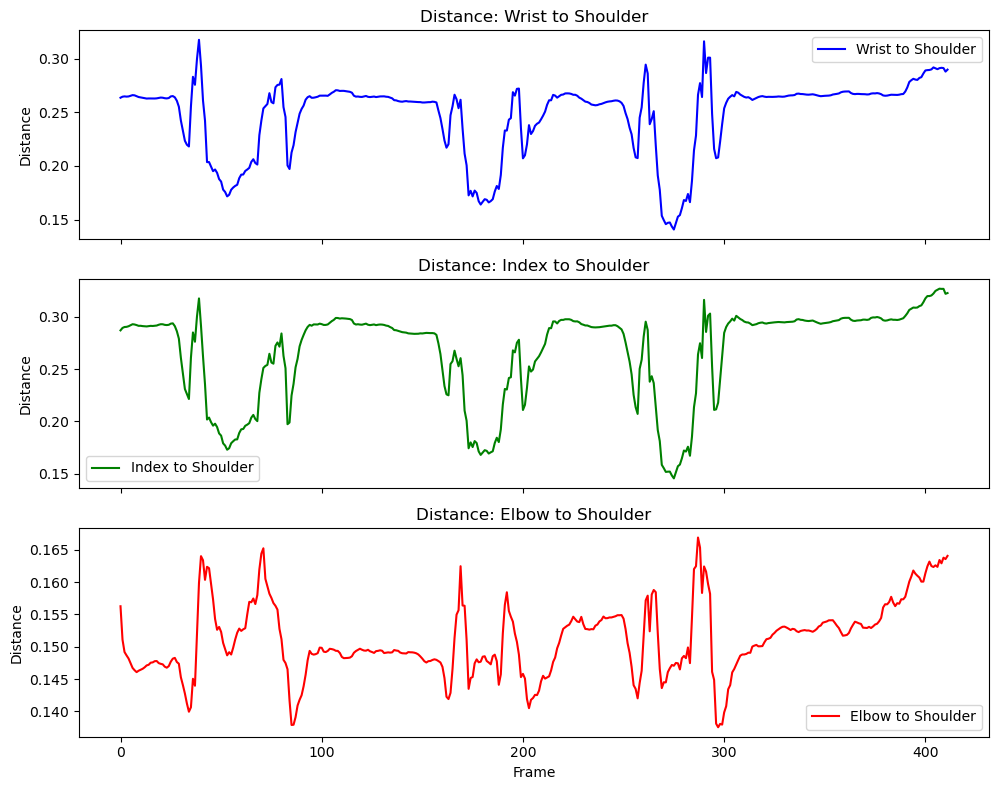

In [6]:
"""
For bicep curls, calculate the euclidean distance between the hands and the shoulders
"""
distances_wrist = []
distances_index = []
distances_elbow = []
for _,row in df.iterrows():
    distances_wrist.append(euclidean(row["LEFT_WRIST"],row["LEFT_SHOULDER"]))
    distances_index.append(euclidean(row["LEFT_SHOULDER"],row["LEFT_THUMB"]))
    distances_elbow.append(euclidean(row["LEFT_SHOULDER"],row["LEFT_ELBOW"]))
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot for distances_wrist
axs[0].plot(distances_wrist, label='Wrist to Shoulder', color='blue')
axs[0].set_title("Distance: Wrist to Shoulder")
axs[0].set_ylabel("Distance")
axs[0].legend()

# Plot for distances_index
axs[1].plot(distances_index, label='Index to Shoulder', color='green')
axs[1].set_title("Distance: Index to Shoulder")
axs[1].set_ylabel("Distance")
axs[1].legend()

# Plot for distances_elbow
axs[2].plot(distances_elbow, label='Elbow to Shoulder', color='red')
axs[2].set_title("Distance: Elbow to Shoulder")
axs[2].set_ylabel("Distance")
axs[2].set_xlabel("Frame")
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()
